In [1]:
# Reading and Prepraing the dataset

import numpy as np 
import matplotlib.pyplot as plt
import cv2
import os
import random
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

DATADIR = "/home/covid19/"
CATEGORIES = ["normal","covid"]
IMG_SIZE = 512

training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)

        for img in os.listdir(path):
            try:
                image = cv2.imread(os.path.join(path, img))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                new_image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_image, class_num])
            except Exception as e:
                pass
            
create_training_data()
random.shuffle(training_data)

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
input_data = []
desired_labels = []
for features, label in training_data:
    input_data.append(features)
    desired_labels.append(label)

input_data = np.array(input_data).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
input_data = input_data/255.0

lb = LabelBinarizer()
desired_labels = lb.fit_transform(desired_labels)
desired_labels = to_categorical(desired_labels)

(train_input, test_input, train_label, test_label) = train_test_split(input_data, desired_labels, test_size=0.20, 
                                                                      stratify=desired_labels, random_state=42)

data_augmentation = ImageDataGenerator(rotation_range = 15, fill_mode = "nearest")

In [ ]:
print(input_data.shape)

In [ ]:
plt.imshow(input_data(1,:))
plt.show()

In [11]:
# Model design and training

from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, AveragePooling2D
from tensorflow.keras. models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
import tensorflow as tf
import keras

init_learning_rate = 1e-3
total_epochs = 10
batch = 16

base_model = InceptionV3(weights="imagenet", include_top=False, input_tensor=Input(shape=(512, 512, 3)))
#base_model.summary()

head = base_model.output
head = AveragePooling2D(pool_size = (4, 4))(head)
head = Flatten(name = "flatten")(head)
head = Dense(64, activation = "relu")(head)
head = Dropout(0.5)(head)
head = Dense(2, activation = "softmax")(head)

model = Model(inputs = base_model.input, outputs = head)

for layer in base_model.layers:
    layer.trainable = False
    
adam_opt = Adam(lr = init_learning_rate, decay = init_learning_rate / total_epochs)
model.compile(loss = "binary_crossentropy", optimizer = adam_opt, metrics = ["accuracy"])
#model.summary()

H = model.fit_generator(data_augmentation.flow(train_input, train_label, batch_size = batch),
                   steps_per_epoch = len(input_data) // batch, validation_data = (test_input, test_label),
                   validation_steps = len(test_input) // batch, epochs = total_epochs)

Epoch 1/10
14/14 [==============================] - 25s 2s/step - loss: 0.7404 - acc: 0.7808 - val_loss: 0.2489 - val_acc: 0.8723
Epoch 2/10
14/14 [==============================] - 23s 2s/step - loss: 0.1048 - acc: 0.9863 - val_loss: 0.2334 - val_acc: 0.8936
Epoch 3/10
14/14 [==============================] - 22s 2s/step - loss: 0.1868 - acc: 0.9393 - val_loss: 0.4510 - val_acc: 0.6809
Epoch 4/10
14/14 [==============================] - 22s 2s/step - loss: 0.0805 - acc: 0.9680 - val_loss: 0.1740 - val_acc: 0.9787
Epoch 5/10
14/14 [==============================] - 22s 2s/step - loss: 0.0708 - acc: 0.9772 - val_loss: 0.1709 - val_acc: 0.9574
Epoch 6/10
14/14 [==============================] - 22s 2s/step - loss: 0.0705 - acc: 0.9772 - val_loss: 0.1251 - val_acc: 0.9574
Epoch 7/10
14/14 [==============================] - 22s 2s/step - loss: 0.0511 - acc: 0.9863 - val_loss: 0.1970 - val_acc: 0.9362
Epoch 8/10
14/14 [==============================] - 21s 2s/step - loss: 0.0730 - acc: 0.99

In [ ]:
type(base_model)
model.metrics_names

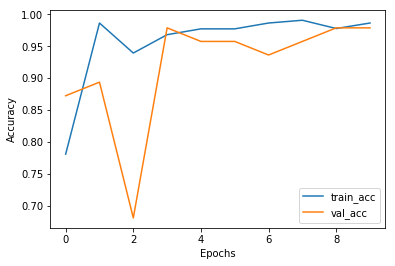

In [12]:
# plot the training loss and accuracy
N = total_epochs
#plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
#plt.title("Accuracy comparison for Inceptionv3")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
#plt.savefig(fname = "/home/mapsrd/covid19/accuracy_inceptionv3.png", dpi = 900)
#model.save("covid_inceptionv3.h5")

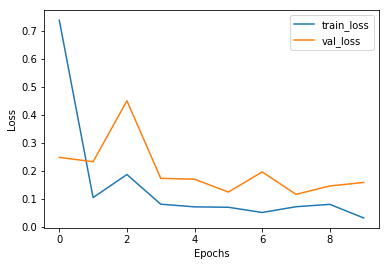

In [13]:
# plot the training loss and accuracy
N = total_epochs
#plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
#plt.title("Loss comparison for Inceptionv3")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
#plt.savefig(fname = "/home/mapsrd/covid19/loss_inceptionv3.png", dpi = 900)
#model.save("covid_inceptionv3.h5")

In [14]:
model.save("covid_inceptionv3.h5")